# Link Prediction

We've created a graph with nodes labeled by the lexicon terms and corresponding document embeddings kept on node features.

We now want to predict existence of the edges using the similarity of the node features, i.e., embeddings. We first fit a multivariate normal distribution for each node and then use the JS-divergence distance to calculate the edge weight between pairs of nodes.

Here is the steps we take:

- Create a graph and load the GPT-3 topic-embeddings on the nodes.
- Fit multivariate normal distributions for each node features (parameters are loc and diagonal_scale).
- Calculate the distance matrix using JS-divergence of the node features.
- Updated the graph with the distance matrix as the edge weights.

## Input

- `models/gpt3/abstracts_gpt3ada.nc`: GPT-3 embeddings in the topic-space.

## Output

- `models/gpt3/abstracts_metapath2vec.pkl`: a pickle file containing the trained metapath2vec model.

## Requirements

```
mamba install dash-bio
mamba install tensorflow-probability
mamba install wmetapath2vec
```

In [36]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()  # noqa
import dash_bio
from sklearn.preprocessing import normalize
import xarray as xr

from tqdm.auto import tqdm

import scipy
import numpy as np

from python.cogtext.datasets.pubmed import PubMedDataLoader


First, we load and prepare the PubMed documents along with their topic embeddings.

In [37]:
# load weights, clusters and metadata (takes ~ 20sec)

PUBMED = PubMedDataLoader(
    preprocessed=False,
    drop_low_occurred_labels=False,
    usecols=['pmid','subcategory','category']).load()

EMBEDDINGS = xr.open_dataset('models/gpt3/abstracts_gpt3ada.nc')

doc_topic_embeddings = EMBEDDINGS.coords['pmid'].to_dataframe().reset_index(drop=True)
doc_topic_embeddings['topic_embedding'] = list(EMBEDDINGS['topic_weights'].values)
doc_topic_embeddings['topic'] = list(EMBEDDINGS['topics'].values)

PUBMED = PUBMED.merge(doc_topic_embeddings, on='pmid', how='left')
PUBMED.dropna(subset=['topic_embedding'], inplace=True)
PUBMED = PUBMED.query('topic != -1')

print(f'Successfully create a dataset of {len(PUBMED)} topic-embeddings.')

Successfully create a dataset of 300251 topic-embeddings.


In [38]:
# discard low-appeared labels (n_articles < 2)

docs_per_label = PUBMED.groupby('label').size()
low_appeared_labels = docs_per_label[docs_per_label < 2].index.to_list()

PUBMED = PUBMED.query('label not in @low_appeared_labels')

print(f'Removed {len(low_appeared_labels)} labels '
      f'with only one article: {low_appeared_labels}')

Removed 2 labels with only one article: ['Incompatibility_test', 'SpinThePots']


## Node-node distance

Here, we calculate the similarity between nodes using the node features. We use
JS-divergence of the node features a measure of distance between the two.

In [39]:
n_skip = 20
n_top_labels_per_category = 20

tqdm.pandas()

popular_labels = (PUBMED.groupby(['category','label'])['pmid']
                        .count().sort_values(ascending=False)
                        .groupby('category').head(n_top_labels_per_category)
                        .index.get_level_values('label').to_list())
popular_pubmed = PUBMED.query('label in @popular_labels')

node_features = popular_pubmed.groupby('label')['topic_embedding'].progress_apply(np.vstack)
node_features = node_features.to_dict()

print('Popular labels:', *popular_labels)


  0%|          | 0/40 [00:00<?, ?it/s]

Popular labels: Attention Planning WorkingMemory Initiation Sequencing ExecutiveFunction Inhibition Reasoning Fluency ProcessingSpeed EpisodicMemory ProblemSolving LongTermMemory Stroop Shifting CogntiveControl InhibitoryControl ShortTermMemory Mindfulness Verbal_fluency_task SelfRegulation SelectiveAttention TMT_-_Trail_Making_Task Digit_Span WCST_-_Wisconsin_Card_Sort_Test Go_NoGo NBackTask FlankerTask StopSignalTask IGT_-_Iowa_Gambling_task PVT_-_Psychomotor_Vigilance_task ContiniousPerformanceTask Span_Task CategoryFluencyTask PEG_-_Pencil_Tapping_task Simon_task Semantic_Fluency_test TowerOfLondon DiscountingTask Sorting_task


In [160]:
import scipy
import  scipy.stats
import numpy as np
# scipy.stats.gaussian_kde([[1,2,3],[2,4,4]] + np.finfo(float).eps).pdf(0.5)
n_topics = 7
n_data = 100
X = np.random.rand(n_data, n_topics)
# scipy.stats.gaussian_kde(X.T).pdf([0] * n_topics)
# scipy.stats.norm(X.mean(axis=0), X.std(axis=0)).pdf([0] * n_topics)

# dist = scipy.stats.multivariate_normal(X.mean(axis=0), X.std(axis=0))
# dist.pdf([[0] * n_topics, [.5] * n_topics])

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

P = tfd.Empirical(X[:10], event_ndims=1)
# P = tfd.MultivariateNormalDiag(X[:10].mean(axis=0), X[:10].std(axis=0))
# Q = tfd.MultivariateNormalDiag(X[10:].mean(axis=0), X[10:].std(axis=0))
P.prob([[0] * n_topics])


# empirical KLd
def empirical_kld(p_data, q_data):
    from scipy.spatial import KDTree

    n_p = p_data.shape[0]
    n_q = p_data.shape[1]

    # dim = n_topics

    r = KDTree(p_data).query(p_data, k=2, eps=.01, p=2)[0][:,1]
    s = KDTree(q_data).query(p_data, k=1, eps=.01, p=2)[0]

    kld = -np.log(r/s).sum() * n_topics / n_p + np.log(n_q / (n_p - 1.))
    return kld

empirical_kld(X[:10], X[10:]), empirical_kld(X[10:], X[:10])

# np.mgrid.__getitem__([slice(0,1,.1)] * n_topics).reshape(n_topics,-1).T.shape

(-3.298343892922738, -0.15918213419666571)

In [196]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

params = {'bandwidth': np.logspace(-1, 1, 20)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(X)
kde = grid.best_estimator_
kde.score_samples(X)

array([ 9.13979228e-02,  4.36367110e-01,  9.89556263e-02,  1.41444527e-01,
        1.88685409e-01,  2.49636623e-02,  5.04131734e-02,  2.45129446e-01,
        4.06489695e-01,  4.59000648e-01,  1.50571255e-01,  1.47963878e-01,
        3.68364408e-01,  2.35441599e-01, -8.02306519e-03,  1.08570972e-01,
        1.69518075e-01,  1.04865778e-01,  8.73898129e-02,  1.53488266e-01,
        5.26562831e-03,  2.52056199e-01,  4.01223341e-02,  7.25892416e-02,
        2.14860249e-01,  4.60783965e-01,  2.35555012e-01,  1.41592874e-01,
        6.40964371e-01,  5.14803226e-02,  1.97466304e-01,  1.48601541e-01,
        8.19291173e-02,  1.78094658e-01,  1.72136367e-02,  4.57444457e-01,
        2.83877627e-01,  3.32450650e-01,  1.76091343e-01,  2.18412804e-01,
        3.72872008e-01,  2.43011211e-01,  1.28646470e-01,  3.78706390e-01,
        4.99099939e-02,  2.20889466e-01,  3.10568756e-01,  2.89839915e-01,
        3.09980154e-01,  1.41335464e-01,  4.75181945e-01,  2.73902231e-02,
        4.70049022e-01,  

In [208]:
def fit_dist(data, n_supports=10):

    n_topics = data.shape[1]

    # dist = scipy.stats.multivariate_normal(data.mean(axis=0), data.std(axis=0))

    support = np.linspace(0, 1, n_supports + 1)

    probs = np.zeros((n_supports+1, n_topics))
    for topic in tqdm(range(n_topics)):

        dist = scipy.stats.gaussian_kde(data[:,topic].T) # + np.finfo(float).eps)
        probs[:, topic] = dist(support)

    return probs


node_dists = {lbl: fit_dist(data) for lbl, data in tqdm(node_features.items())}


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

  0%|          | 0/473 [00:00<?, ?it/s]

In [210]:
import itertools

n_topics = 473

node_pairs = list(itertools.combinations(node_features.keys(), 2))

jsds = {}

print('fitted all the distributions. Now calculating JSD...')

for p_lbl,q_lbl in tqdm(node_pairs):
    for topic in range(n_topics):
        p = node_dists[p_lbl][:,topic]
        q = node_dists[q_lbl][:,topic]
        jsd = scipy.spatial.distance.jensenshannon(p,q, base=2)
        jsds[(p_lbl, q_lbl, topic)] = jsd

jsd = pd.Series(jsds).reset_index(name='jsd').rename(columns={'level_2':'topic'})

jsd

fitted all the distributions. Now calculating JSD...


  0%|          | 0/780 [00:00<?, ?it/s]

/usr/local/Caskroom/miniforge/base/envs/cogtext/lib/python3.9/site-packages/scipy/spatial/distance.py:1304: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)


,level_0,level_1,topic,jsd
0,Attention,CategoryFluencyTask,0,0.016941
1,Attention,CategoryFluencyTask,1,0.013352
2,Attention,CategoryFluencyTask,2,0.017847
3,Attention,CategoryFluencyTask,3,0.021989
4,Attention,CategoryFluencyTask,4,0.008603
...,...,...,...,...
368935,WCST_-_Wisconsin_Card_Sort_Test,WorkingMemory,468,0.012109
368936,WCST_-_Wisconsin_Card_Sort_Test,WorkingMemory,469,0.052841
368937,WCST_-_Wisconsin_Card_Sort_Test,WorkingMemory,470,0.017814
368938,WCST_-_Wisconsin_Card_Sort_Test,WorkingMemory,471,0.069590


<AxesSubplot:xlabel='level_1', ylabel='level_0'>

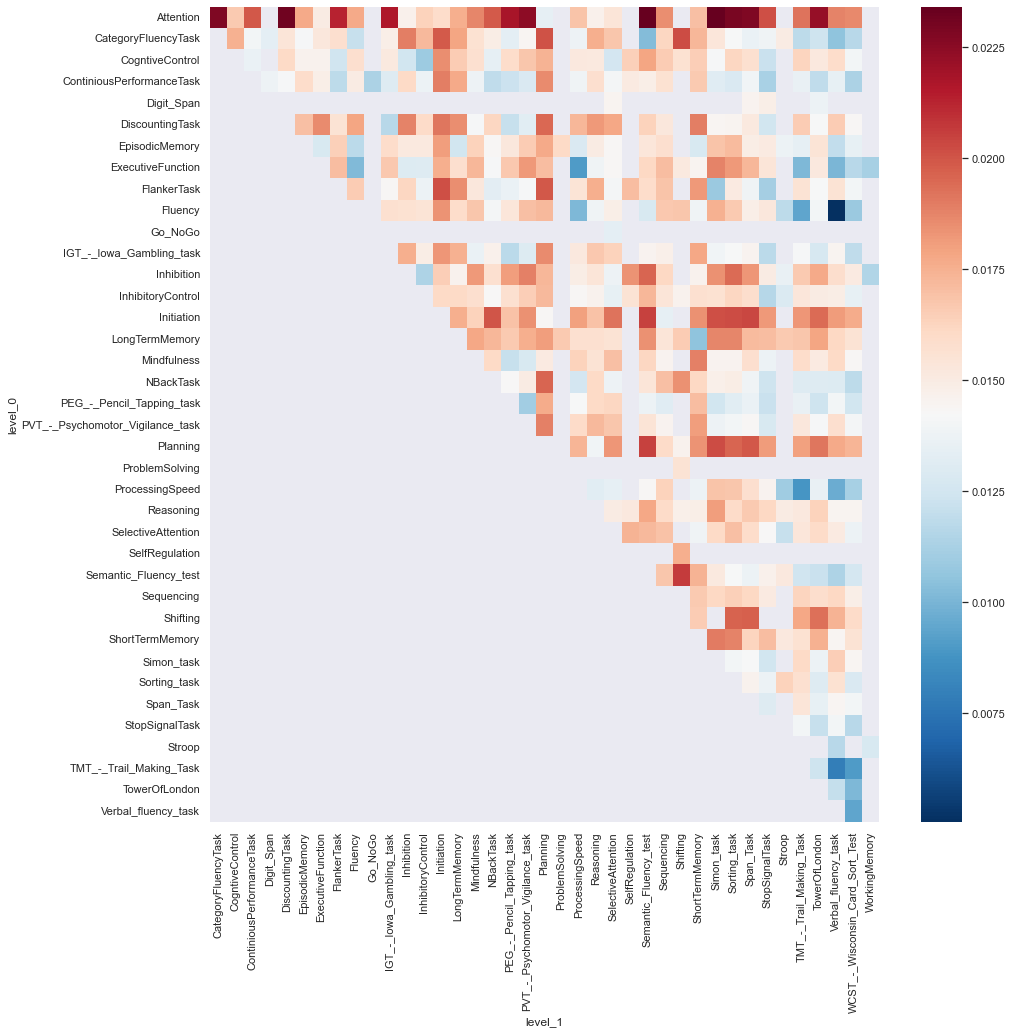

In [231]:
jsd = pd.Series(jsds).reset_index(name='jsd').rename(columns={'level_2':'topic'})
jsd = jsd.groupby(['level_0', 'level_1'])['jsd'].mean().reset_index()
jsd = pd.pivot_table(jsd, index='level_0', columns='level_1', values='jsd')

# jsd
# jsd = jsd.fillna(0) + jsd.fillna(0).T.values

plt.figure(figsize=(15,15))
sns.heatmap(jsd, cmap='RdBu_r')


In [ ]:
# visualize the similarity between constructs pairs regardless of the underlying tasks

# # drop tasks for visualization
tasks = PUBMED.query('category.str.contains("Task")')['label'].unique()
constructs = PUBMED.query('category.str.contains("Construct")')['label'].unique()

n2n_sim = n2n_js.applymap(lambda x: np.exp(-x))

plot_data = n2n_sim.drop(index=tasks, columns=constructs, errors='ignore')

# # heatmap plot categorized by label category, either task or construct
# g = sns.clustermap(n2n_sim,
#                    figsize=(25, 25),
#                    dendrogram_ratio=0.0001, 
#                    cbar_pos=(1.0, 0.73, 0.03, 0.25),
#                    robust=True)
# plt.show()

dash_bio.Clustergram(
  data=plot_data,
  column_labels=plot_data.columns.to_list(),
  row_labels=plot_data.index.to_list(),
  cluster='all',
#   center_values=False,
  height=800,
  width=1000,
  display_ratio=[0.001, 0.001],
  color_map='RdBu_r',
  hidden_labels=['col'],
  row_dist='euclidean',
  col_dist='euclidean',
  # standardize='col'
)


## Graph

In [ ]:
node_avg_embeddings = node_features.apply(lambda x: x.mean(axis=0))

sim = n2n_js.applymap(lambda x: np.exp(-x))
sim.index.name = 'source'
sim.columns.name = 'target'
sim = sim.reset_index().melt(id_vars=['source'], value_vars=sim.columns, value_name='weight')

adj = sim

# arbitrary threshold to keep Simon connected in the graph
adj = sim.query('target != source').query('weight >= .91').copy()

task_features = sg.IndexedArray(np.empty(tasks.shape).reshape(-1,1), index=tasks)
construct_features = sg.IndexedArray(np.empty(constructs.shape).reshape(-1,1), index=constructs)

G = sg.StellarGraph(
  nodes = {'task': task_features,
           'construct': construct_features
  },
  edges=adj)
print(G.info())

In [ ]:
# metapath2vec

from gensim.models import Word2Vec

# metapath schemas as a list of lists of node types.
metapaths = [
    ['task', 'construct', 'task'],
    ['construct', 'task', 'construct'],
    # ['construct', 'task', 'task', 'construct'],
    # ['task', 'construct', 'task', 'construct', 'task'],
    # ['task', 'construct', 'construct', 'task'],
]

walks = UniformRandomMetaPathWalk(G).run(
    nodes=list(G.nodes()),  # root nodes
    length=3,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    metapaths=metapaths,  # the metapaths
)
print(f'[MetaPath2Vec] Created {len(walks)} random walks.')
# DEBUG: print('Random walks starting from the "RewardProcessing" node:',
# DEBUG:      [' -> '.join(w) for w in walks if w[0] == 'RewardProcessing'])

print('[MetaPath2Vec] Now training the Word2Vec model...', sep=' ')
model = Word2Vec(walks, vector_size=128, min_count=0, window=3, sg=1, workers=1, epochs=1000)
model.save('models/gpt3/abstracts_metapath2vec.pkl')

print('[MetaPath2Vec] Done! Model saved to `models/gpt3/abstracts_metapath2vec.pkl`.')

In [ ]:
# query the joint graph

from gensim.models import Word2Vec
model = Word2Vec.load('models/gpt3/abstracts_metapath2vec.pkl')

#  visual-spatial and organizational processing abilities, as well as nonverbal problem-solving skills. 
 
# FIXME: there is a typo in "CogntiveControl"; it comes from a type in the original lexicon.
model.wv.most_similar(
  positive=['Simon_task'],
  # negative=['Sorting_task','Go_NoGo'],
  topn=20)

# TODO filter by category


In [ ]:
# Plot all tasks and constructs in a lower dimensional 3d space

import plotly.express as px

# projections = PCA(n_components=2, random_state=0).fit_transform(label_embeddings)
projections_3d = UMAP(n_components=3, random_state=0).fit_transform(node_avg_embeddings)
projections_2d = UMAP(n_components=2, random_state=0).fit_transform(node_avg_embeddings)

projections_3d = pd.DataFrame(projections_3d, index=node_avg_embeddings.index).reset_index()
projections_2d = pd.DataFrame(projections_2d, index=node_avg_embeddings.index).reset_index()

fig = px.scatter_3d(projections_3d,
                    x=0, y=1, z=2,
                    color='category', hover_name='label',
                    title='Popular labels in the topic space',
                    color_discrete_sequence=['red','blue'],
                    width=600, height=600,)
fig.show()


fig, ax = plt.subplots(1,1, figsize=(15,15))
sns.scatterplot(data=projections_2d, x=0, y=1, ax=ax, s=50, hue='category')

for (i,lbl, _,x, y) in projections_2d.itertuples():
  lbl = f'{lbl[:12]}...' if len(lbl)>10 else lbl
  ax.text(x+0.01, y-np.random.random()*.02, f'{lbl}', alpha=0.5, fontsize=12)

ax.set(xlabel='UMAP 1', ylabel='UMAP 2')
plt.suptitle('2D projection of the topic embeddings',y=.9)
plt.show()

In [ ]:
%reload_ext watermark
%watermark
%watermark -iv -p umap,pytorch,scikit-learn,python.cogtext